In [1]:
import pandas as pd

from sktime.datatypes import get_examples
from sktime.transformations.hierarchical.aggregate import aggregate_df
from sktime.transformations.hierarchical.reconcile import reconciler

# https://otexts.com/fpp3/hierarchical.html
# https://github.com/robjhyndman/reconciliation_review_talk/blob/main/10years_reconciliation.pdf

# Hierarchical dataset

In [2]:
df = get_examples(mtype="pd_multiindex_hier", as_scitype="Hierarchical")
df = df[0]

df

var_0  var_1
foo bar timepoints              
a   0   0               1      4
        1               2      5
        2               3      6
    1   0               1      4
        1               2     55
        2               3      6
    2   0               1     42
        1               2      5
        2               3      6
b   0   0               1      4
        1               2      5
        2               3      6
    1   0               1      4
        1               2     55
        2               3      6
    2   0               1     42
        1               2      5
        2               3      6

## Aggregate Hierarchy

Now we have the full forecasting dataset

In [5]:
agg_df = aggregate_df(flatten_single_levels=True)

agg_df.fit_transform(X=df)

var_0  var_1
foo     bar     timepoints              
__total __total 0               6    100
                1              12    130
                2              18     36
a       0       0               1      4
                1               2      5
                2               3      6
        1       0               1      4
                1               2     55
                2               3      6
        2       0               1     42
                1               2      5
                2               3      6
        __total 0               3     50
                1               6     65
                2               9     18
b       0       0               1      4
                1               2      5
                2               3      6
        1       0               1      4
                1               2     55
                2               3      6
        2       0               1     42
                1               2      5
                2               3      6
        __total 0               3     50
                1               6     65
                2               9     18

Let's test with bottom levels that span two nodes

- i.e. mid levels that are only present at a subset of bottom nodes

In [6]:
cols = ["foo", "foo2", "bar", "timepoints"] + [f"var_{i}" for i in range(2)]

Xlist = [
    pd.DataFrame(
        [["a", "a1", 0, 0, 1, 4], ["a", "a1", 0, 1, 2, 5], ["a", "a1", 0, 2, 3, 6]],
        columns=cols,
    ),
    pd.DataFrame(
        [["a", "a1", 1, 0, 1, 4], ["a", "a1", 1, 1, 2, 55], ["a", "a1", 1, 2, 3, 6]],
        columns=cols,
    ),
    pd.DataFrame(
        [["a", "a2", 2, 0, 1, 42], ["a", "a2", 2, 1, 2, 5], ["a", "a2", 2, 2, 3, 6]],
        columns=cols,
    ),
    pd.DataFrame(
        [["b", "b1", 0, 0, 1, 4], ["b", "b1", 0, 1, 2, 5], ["b", "b1", 0, 2, 3, 6]],
        columns=cols,
    ),
    pd.DataFrame(
        [["b", "b2", 1, 0, 1, 4], ["b", "b2", 1, 1, 2, 55], ["b", "b2", 1, 2, 3, 6]],
        columns=cols,
    ),
    pd.DataFrame(
        [["b", "b2", 2, 0, 1, 42], ["b", "b2", 2, 1, 2, 5], ["b", "b2", 2, 2, 3, 6]],
        columns=cols,
    ),
]
X = pd.concat(Xlist)
X = X.set_index(["foo", "foo2", "bar", "timepoints"])

X

var_0  var_1
foo foo2 bar timepoints              
a   a1   0   0               1      4
             1               2      5
             2               3      6
         1   0               1      4
             1               2     55
             2               3      6
    a2   2   0               1     42
             1               2      5
             2               3      6
b   b1   0   0               1      4
             1               2      5
             2               3      6
    b2   1   0               1      4
             1               2     55
             2               3      6
         2   0               1     42
             1               2      5
             2               3      6

Note flatten single levels is the default option

- see that `(a, a2, 2, *)` and `(b, b1, 0, *)` don't contain `__total`

In [8]:
agg_df.fit_transform(X=X)

var_0  var_1
foo     foo2    bar     timepoints              
__total __total __total 0               6    100
                        1              12    130
                        2              18     36
a       __total __total 0               3     50
                        1               6     65
                        2               9     18
        a1      0       0               1      4
                        1               2      5
                        2               3      6
                1       0               1      4
                        1               2     55
                        2               3      6
                __total 0               2      8
                        1               4     60
                        2               6     12
        a2      2       0               1     42
                        1               2      5
                        2               3      6
b       __total __total 0               3     50
                        1               6     65
                        2               9     18
        b1      0       0               1      4
                        1               2      5
                        2               3      6
        b2      1       0               1      4
                        1               2     55
                        2               3      6
                2       0               1     42
                        1               2      5
                        2               3      6
                __total 0               2     46
                        1               4     60
                        2               6     12

# Forecasting Example

Let's generate a hierarchical dataset similar to the last example from the flights dataset

- Generate dataset
- Generate full hierarchy
- Forecast each level
- Reconcile

## Generate Dataset

In [9]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

In [10]:
zone1 = load_airline()

zone1

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

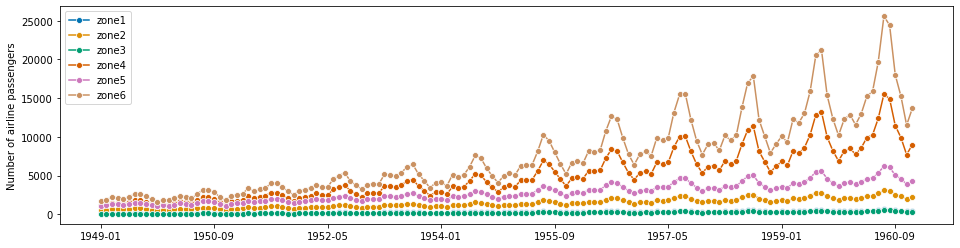

In [11]:
# plotting for visualization
plot_series(
    zone1,
    10 + zone1 * 5,
    -50 + zone1 * 0.9,
    zone1 ** 1.5,
    -20 + 10 * zone1,
    10 + (10 * zone1) + (0.05 * (zone1 ** 2)),
    labels=["zone1", "zone2", "zone3", "zone4", "zone5", "zone6"],
)

In [12]:
df = pd.DataFrame(zone1, index=zone1.index).rename(
    columns={"Number of airline passengers": "zone1"}
)

df["zone2"] = 10 + zone1 * 5
df["zone3"] = zone1 * 0.9 - 50
df["zone4"] = zone1 ** 1.5
df["zone5"] = zone1 * 10 - 500
df["zone6"] = 10 + (10 * zone1) + (0.05 * (zone1 ** 2))

df = (
    df.melt(ignore_index=False)
    .set_index(["variable", df.melt(ignore_index=False).index])
    .rename_axis(["airport", "timepoints"], axis=0)
    .rename(columns={"value": "passengers"})
)

# df['country'] = "USA"
df.loc[
    df.index.get_level_values(level="airport").isin(["zone1", "zone2", "zone3"]),
    "state",
] = "CA"
df.loc[
    df.index.get_level_values(level="airport").isin(["zone1", "zone2"]), "city"
] = "LA"
df.loc[df.index.get_level_values(level="airport").isin(["zone3"]), "city"] = "SF"


df.loc[
    df.index.get_level_values(level="airport").isin(["zone4", "zone5", "zone6"]),
    "state",
] = "NY"
df.loc[
    df.index.get_level_values(level="airport").isin(["zone4", "zone5"]), "city"
] = "NYC"
df.loc[df.index.get_level_values(level="airport").isin(["zone6"]), "city"] = "BF"

df = df.set_index(["state", "city", df.index])
df


# df.droplevel(level=-1).index.unique()

passengers
state city airport timepoints            
CA    LA   zone1   1949-01         112.00
                   1949-02         118.00
                   1949-03         132.00
                   1949-04         129.00
                   1949-05         121.00
...                                   ...
NY    BF   zone6   1960-08       24431.80
                   1960-09       17993.20
                   1960-10       15246.05
                   1960-11       11515.00
                   1960-12       13661.20

[864 rows x 1 columns]

## Generate full hierarchy

In [13]:
df_fh = agg_df.fit_transform(X=df)

df_fh

c:\users\ciaran.gilbert\github\sktime\sktime\datatypes\_hierarchical\_check.py:100: PerformanceWarning: indexing past lexsort depth may impact performance.
  check_pddataframe_series(obj.loc[i], return_metadata=True) for i in inst_inds
c:\users\ciaran.gilbert\github\sktime\sktime\datatypes\_hierarchical\_check.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  metadata["is_equal_length"] = _list_all_equal([len(obj.loc[i]) for i in inst_inds])


passengers
state   city    airport timepoints              
CA      LA      __total 1949-01       682.000000
                        1949-02       718.000000
                        1949-03       802.000000
                        1949-04       784.000000
                        1949-05       736.000000
...                                          ...
__total __total __total 1960-08     49051.142754
                        1960-09     37488.138512
                        1960-10     32395.039765
                        1960-11     25267.882887
                        1960-12     29400.951386

[1584 rows x 1 columns]

## Forecast each level

here we will forecast each unique level outside `timepoints`

In [14]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [15]:
model_ids = df_fh.droplevel(level="timepoints").index.unique()

model_ids

MultiIndex([(     'CA',      'LA', '__total'),
            (     'CA',      'LA',   'zone1'),
            (     'CA',      'LA',   'zone2'),
            (     'CA',      'SF',   'zone3'),
            (     'CA', '__total', '__total'),
            (     'NY',      'BF',   'zone6'),
            (     'NY',     'NYC', '__total'),
            (     'NY',     'NYC',   'zone4'),
            (     'NY',     'NYC',   'zone5'),
            (     'NY', '__total', '__total'),
            ('__total', '__total', '__total')],
           names=['state', 'city', 'airport'])

In [16]:
# Now set up loop for forecasting
# # for i in model_ids:
# mods = {}
# prds = {}

# for i in model_ids:
#     # i = model_ids[0]
#     y_train, y_test = temporal_train_test_split(df_fh.loc[i], test_size=36)
#     fh = ForecastingHorizon(y_test.index, is_relative=False)
#     forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
#     mods[i] = forecaster.fit(y_train)
#     prds[i] = forecaster.predict(fh)
#     # plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
#     print(i)
#     print(mean_absolute_percentage_error(y_test, prds[i], symmetric=True))
# prds = (
#     pd.concat(prds)
#     .rename_axis(df_fh.index.names, axis=0)
#     .rename(columns={"passengers": "y_pred"})
# )

# # join with meas
# prds = pd.concat([prds, df_fh], axis=1, join="inner").rename(
#     columns={"passengers": "y_true"}
# )

In [17]:
# # for i in model_ids:
# mods = {}
# prds = {}

# for i in model_ids:
# i = model_ids[0]
# y_train, y_test = temporal_train_test_split(df_fh, test_size=36)
fh = ForecastingHorizon([1, 2, 3, 4, 5, 6], is_relative=True)
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
mods = forecaster.fit(df_fh)
prds = forecaster.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# print(i)
# print(mean_absolute_percentage_error(df_fh, prds, symmetric=True))
prds

# prds.index = prds.index.rename(['state', 'city', 'airport', 'timepoints'])

# prds

C:\Users\Ciaran.Gilbert\Anaconda3\envs\sktime-dev\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Ciaran.Gilbert\Anaconda3\envs\sktime-dev\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


passengers
state   city    airport                      
CA      LA      __total 1961-01   2732.066374
                        1961-02   2587.047026
                        1961-03   2811.963577
                        1961-04   3028.947407
                        1961-05   3083.885169
...                                       ...
__total __total __total 1961-02  29806.756414
                        1961-03  33382.191740
                        1961-04  37206.206925
                        1961-05  38189.812430
                        1961-06  44717.270499

[66 rows x 1 columns]

## Reconcile - Bottom Up

Bottom up is easy we just sum the bottome levels much like aggregate function.

But we want it to be compatible with other methods which go like
    
    - get y 'base' forecasts for all series (previous section)
    - get S matrix from df index (defined by hierarchy structure)
    - get G matrix for recon (defined by recon method)
    - reconcile forecasts - SGy (all methods)


In [18]:
transformer = reconciler(method="bu")

fitted_transfrom = transformer.fit(X=prds[["passengers"]])

fitted_transfrom.s_matrix

# https://stackoverflow.com/questions/54307300/what-causes-indexing-past-lexsort-depth-warning-in-pandas

C:\Users\Ciaran.Gilbert\Anaconda3\envs\sktime-dev\lib\site-packages\IPython\core\interactiveshell.py:3185: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


zone1  zone2  zone3  zone6  zone4  zone5
state   city    airport                                          
CA      LA      __total    1.0    1.0    0.0    0.0    0.0    0.0
                zone1      1.0    0.0    0.0    0.0    0.0    0.0
                zone2      0.0    1.0    0.0    0.0    0.0    0.0
        SF      zone3      0.0    0.0    1.0    0.0    0.0    0.0
        __total __total    1.0    1.0    1.0    0.0    0.0    0.0
NY      BF      zone6      0.0    0.0    0.0    1.0    0.0    0.0
        NYC     __total    0.0    0.0    0.0    0.0    1.0    1.0
                zone4      0.0    0.0    0.0    0.0    1.0    0.0
                zone5      0.0    0.0    0.0    0.0    0.0    1.0
        __total __total    0.0    0.0    0.0    1.0    1.0    1.0
__total __total __total    1.0    1.0    1.0    1.0    1.0    1.0

In [19]:
fitted_transfrom.g_matrix

state        CA                              NY                              \
city         LA                SF __total    BF     NYC             __total   
airport __total zone1 zone2 zone3 __total zone6 __total zone4 zone5 __total   
zone1       0.0   1.0   0.0   0.0     0.0   0.0     0.0   0.0   0.0     0.0   
zone2       0.0   0.0   1.0   0.0     0.0   0.0     0.0   0.0   0.0     0.0   
zone3       0.0   0.0   0.0   1.0     0.0   0.0     0.0   0.0   0.0     0.0   
zone6       0.0   0.0   0.0   0.0     0.0   1.0     0.0   0.0   0.0     0.0   
zone4       0.0   0.0   0.0   0.0     0.0   0.0     0.0   1.0   0.0     0.0   
zone5       0.0   0.0   0.0   0.0     0.0   0.0     0.0   0.0   1.0     0.0   

state   __total  
city    __total  
airport __total  
zone1       0.0  
zone2       0.0  
zone3       0.0  
zone6       0.0  
zone4       0.0  
zone5       0.0

In [20]:
prds["y_recon_bu"] = fitted_transfrom.transform(X=prds[["passengers"]])

prds

passengers    y_recon_bu
state   city    airport                                    
CA      LA      __total 1961-01   2732.066374   2729.564708
                        1961-02   2587.047026   2585.874863
                        1961-03   2811.963577   2814.643918
                        1961-04   3028.947407   3026.449756
                        1961-05   3083.885169   3081.670177
...                                       ...           ...
__total __total __total 1961-02  29806.756414  29835.687690
                        1961-03  33382.191740  33368.199661
                        1961-04  37206.206925  37224.776921
                        1961-05  38189.812430  38227.431458
                        1961-06  44717.270499  44789.712370

[66 rows x 2 columns]

This seems to work fine

In [21]:
prds.loc[prds.index.get_level_values(level=-1) == "1961-01"]

passengers    y_recon_bu
state   city    airport                                    
CA      LA      __total 1961-01   2732.066374   2729.564708
                zone1   1961-01    451.577217    451.577217
                zone2   1961-01   2277.987491   2277.987491
        SF      zone3   1961-01    356.419880    356.419880
        __total __total 1961-01   3088.948472   3085.984588
NY      BF      zone6   1961-01  15240.106608  15240.106608
        NYC     __total 1961-01  13837.207873  13828.414920
                zone4   1961-01   9791.659372   9791.659372
                zone5   1961-01   4036.755548   4036.755548
        __total __total 1961-01  29008.347265  29068.521528
__total __total __total 1961-01  32108.468058  32154.506116

## OLS reconciliation

    - Now all we need is the new g_matrix method

In [22]:
transformer_ols = reconciler(method="ols")

fitted_transfrom_ols = transformer_ols.fit(X=prds[["passengers"]])

fitted_transfrom_ols.g_matrix

C:\Users\Ciaran.Gilbert\Anaconda3\envs\sktime-dev\lib\site-packages\IPython\core\interactiveshell.py:3377: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Ciaran.Gilbert\Anaconda3\envs\sktime-dev\lib\site-packages\IPython\core\interactiveshell.py:3185: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


state          CA                                                NY            \
city           LA                            SF   __total        BF       NYC   
airport   __total     zone1     zone2     zone3   __total     zone6   __total   
zone1    0.236111  0.618056 -0.381944 -0.145833  0.090278 -0.020833 -0.013889   
zone2    0.236111 -0.381944  0.618056 -0.145833  0.090278 -0.020833 -0.013889   
zone3   -0.291667 -0.145833 -0.145833  0.562500  0.270833 -0.062500 -0.041667   
zone6   -0.041667 -0.020833 -0.020833 -0.062500 -0.104167  0.562500 -0.291667   
zone4   -0.013889 -0.006944 -0.006944 -0.020833 -0.034722 -0.145833  0.236111   
zone5   -0.013889 -0.006944 -0.006944 -0.020833 -0.034722 -0.145833  0.236111   

state                                   __total  
city                          __total   __total  
airport     zone4     zone5   __total   __total  
zone1   -0.006944 -0.006944 -0.034722  0.055556  
zone2   -0.006944 -0.006944 -0.034722  0.055556  
zone3   -0.020833 -0.020833 -0.104167  0.166667  
zone6   -0.145833 -0.145833  0.270833  0.166667  
zone4    0.618056 -0.381944  0.090278  0.055556  
zone5   -0.381944  0.618056  0.090278  0.055556

In [23]:
prds["y_recon_ols"] = fitted_transfrom_ols.transform(X=prds[["passengers"]])

prds

passengers    y_recon_bu   y_recon_ols
state   city    airport                                                  
CA      LA      __total 1961-01   2732.066374   2729.564708   2730.100376
                        1961-02   2587.047026   2585.874863   2586.286825
                        1961-03   2811.963577   2814.643918   2814.244914
                        1961-04   3028.947407   3026.449756   3028.815865
                        1961-05   3083.885169   3081.670177   3083.160551
...                                       ...           ...           ...
__total __total __total 1961-02  29806.756414  29835.687690  29810.160133
                        1961-03  33382.191740  33368.199661  33379.662344
                        1961-04  37206.206925  37224.776921  37208.674126
                        1961-05  38189.812430  38227.431458  38194.964937
                        1961-06  44717.270499  44789.712370  44727.944995

[66 rows x 3 columns]

This seems to work fine as well

    - note the bottom level forecasts have now changed as well

In [24]:
prds.loc[prds.index.get_level_values(level=-1) == "1961-01"]

passengers    y_recon_bu   y_recon_ols
state   city    airport                                                  
CA      LA      __total 1961-01   2732.066374   2729.564708   2730.100376
                zone1   1961-01    451.577217    451.577217    451.845051
                zone2   1961-01   2277.987491   2277.987491   2278.255325
        SF      zone3   1961-01    356.419880    356.419880    354.721716
        __total __total 1961-01   3088.948472   3085.984588   3084.822092
NY      BF      zone6   1961-01  15240.106608  15240.106608  15213.158817
        NYC     __total 1961-01  13837.207873  13828.414920  13816.311694
                zone4   1961-01   9791.659372   9791.659372   9785.607759
                zone5   1961-01   4036.755548   4036.755548   4030.703935
        __total __total 1961-01  29008.347265  29068.521528  29029.470511
__total __total __total 1961-01  32108.468058  32154.506116  32114.292603

## WLS structural reconciliation

    - Now all we need is the new g_matrix method

In [27]:
transformer_wls = reconciler(method="wls_str")

fitted_transfrom_wls = transformer_wls.fit(X=prds[["passengers"]])

fitted_transfrom_wls.g_matrix

C:\Users\Ciaran.Gilbert\Anaconda3\envs\sktime-dev\lib\site-packages\IPython\core\interactiveshell.py:3377: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Ciaran.Gilbert\Anaconda3\envs\sktime-dev\lib\site-packages\IPython\core\interactiveshell.py:3185: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


state          CA                                                NY            \
city           LA                            SF   __total        BF       NYC   
airport   __total     zone1     zone2     zone3   __total     zone6   __total   
zone1    0.299301  0.574825 -0.425175 -0.125874  0.071329 -0.010490 -0.008392   
zone2    0.299301 -0.425175  0.574825 -0.125874  0.071329 -0.010490 -0.008392   
zone3   -0.503497 -0.125874 -0.125874  0.370629  0.356643 -0.052448 -0.041958   
zone6   -0.041958 -0.010490 -0.010490 -0.052448 -0.220280  0.370629 -0.503497   
zone4   -0.008392 -0.002098 -0.002098 -0.010490 -0.044056 -0.125874  0.299301   
zone5   -0.008392 -0.002098 -0.002098 -0.010490 -0.044056 -0.125874  0.299301   

state                                   __total  
city                          __total   __total  
airport     zone4     zone5   __total   __total  
zone1   -0.002098 -0.002098 -0.044056  0.054545  
zone2   -0.002098 -0.002098 -0.044056  0.054545  
zone3   -0.010490 -0.010490 -0.220280  0.272727  
zone6   -0.125874 -0.125874  0.356643  0.272727  
zone4    0.574825 -0.425175  0.071329  0.054545  
zone5   -0.425175  0.574825  0.071329  0.054545

In [28]:
prds["y_recon_wls"] = fitted_transfrom_wls.transform(X=prds[["passengers"]])

prds

passengers    y_recon_bu   y_recon_ols  \
state   city    airport                                                     
CA      LA      __total 1961-01   2732.066374   2729.564708   2730.100376   
                        1961-02   2587.047026   2585.874863   2586.286825   
                        1961-03   2811.963577   2814.643918   2814.244914   
                        1961-04   3028.947407   3026.449756   3028.815865   
                        1961-05   3083.885169   3081.670177   3083.160551   
...                                       ...           ...           ...   
__total __total __total 1961-02  29806.756414  29835.687690  29810.160133   
                        1961-03  33382.191740  33368.199661  33379.662344   
                        1961-04  37206.206925  37224.776921  37208.674126   
                        1961-05  38189.812430  38227.431458  38194.964937   
                        1961-06  44717.270499  44789.712370  44727.944995   

                                  y_recon_wls  
state   city    airport                        
CA      LA      __total 1961-01   2731.617189  
                        1961-02   2587.185662  
                        1961-03   2813.507033  
                        1961-04   3029.547609  
                        1961-05   3084.295264  
...                                       ...  
__total __total __total 1961-02  29806.832855  
                        1961-03  33381.698836  
                        1961-04  37206.293278  
                        1961-05  38190.420073  
                        1961-06  44719.187655  

[66 rows x 4 columns]

In [29]:
prds.loc[prds.index.get_level_values(level=-1) == "1961-01"]

passengers    y_recon_bu   y_recon_ols  \
state   city    airport                                                     
CA      LA      __total 1961-01   2732.066374   2729.564708   2730.100376   
                zone1   1961-01    451.577217    451.577217    451.845051   
                zone2   1961-01   2277.987491   2277.987491   2278.255325   
        SF      zone3   1961-01    356.419880    356.419880    354.721716   
        __total __total 1961-01   3088.948472   3085.984588   3084.822092   
NY      BF      zone6   1961-01  15240.106608  15240.106608  15213.158817   
        NYC     __total 1961-01  13837.207873  13828.414920  13816.311694   
                zone4   1961-01   9791.659372   9791.659372   9785.607759   
                zone5   1961-01   4036.755548   4036.755548   4030.703935   
        __total __total 1961-01  29008.347265  29068.521528  29029.470511   
__total __total __total 1961-01  32108.468058  32154.506116  32114.292603   

                                  y_recon_wls  
state   city    airport                        
CA      LA      __total 1961-01   2731.617189  
                zone1   1961-01    452.603458  
                zone2   1961-01   2279.013731  
        SF      zone3   1961-01    356.547750  
        __total __total 1961-01   3088.164939  
NY      BF      zone6   1961-01  15200.904953  
        NYC     __total 1961-01  13819.768620  
                zone4   1961-01   9787.336222  
                zone5   1961-01   4032.432398  
        __total __total 1961-01  29020.673573  
__total __total __total 1961-01  32108.838513

In [ ]:
# for i in model_ids:
#     # print(i)
#     # print(
#     #     mean_absolute_percentage_error(
#     #         prds.loc[i, "y_true"], prds.loc[i, "y_pred"], symmetric=True
#     #     )
#     # )
#     # print(
#     #     mean_absolute_percentage_error(
#     #         prds.loc[i, "y_true"], prds.loc[i, "y_reco_bu"], symmetric=True
#     #     )
#     # )
#     # print(
#     #     mean_absolute_percentage_error(
#     #         prds.loc[i, "y_true"], prds.loc[i, "y_reco_ols"], symmetric=True
#     #     )
#     # )
#     plot_series(
#         prds.loc[i, 'y_true'],
#         prds.loc[i, 'y_pred'],
#         prds.loc[i, 'y_reco_bu'],
#         prds.loc[i, 'y_reco_ols'],
#         labels=["y_test", "y_pred", "y_pred_bu", "y_pred_ols"],
#     )

# index = ("LA", "zone1", "sth")
# "__".join(index)

So we could maybe work it like this


class (panel_forecaster)
    
    - fit
    - predict
    - train_test_temporal split?
    - list of model specs

class hierarchical_forecaster(panel_forecaster)
    
    Includes the aggregated levels for the panel.
    
    Inherits methods from above and adds g matrix methods that need information from model fits/original data

    - get_g_matrix_wlsvar
    - get_g_matrix_mint
    - get_g_matrix_mint_shrink
    - get_g_matrix_topdown
    - predict generates multiindex

class reconcile(Transfromer, predictions: multi-index with '__total' present, method = "bu"):

    Inherets transfromer methods? and includes reconciliation methods that don't depend on historic/residual data.

    Checks we have predicttions from hierarchical forecaster then

    - fit
    - predict, i.e. reconcile from this notebook
    - get_s_matrix
    - get_g_matrix_bu
    - get_g_matrix_ols
    - get_g_matrix_wlsstr
